This code uses digital terrain models (DTMs) and digital surface models (DSMs) to calculate the bushiness (% bush) of the habitat within a 100m radius of the group's location at the start of each flight. The DTMs and DSMs were created using DJI and eBee drones to photograph the landscape in a grid around the observation area. These photos were then processed using the photogrammetry software Pix4D.

The size of the DTMs, DSMs, and clipped vegetation raster files prevents them from being included in this repository. Code relying on these files below has been commented out.

The code also uses elevation data from NASA's SRTM dataset to calculate the difference in elevation between the launch point and the group's location, and adjust's the drone's "ascent" measurement to reflect this.

Tasks:
1. Upsample DTMs to match the resolution of the DSMs
2. Crop DSMs and upsampled DTMs around the group start location for each observation.
3. Create vegetation rasters by subtracting cropped DTMs from DSMs. Save cropped vegetation rasters.
4. Read in each cropped vegetation raster and calculate proportion of each circle taht is 1; save this "bushiness score" in the env_variables_clip.csv file
5. Use SRTM raster to get the difference in group elevation between the launch location and the group start location for each observation. Save this value in the drone_variables_clip2.csv file
6. Generate plots demonstrating the validity of using SRTM data to account for ground elevation differences.

Note that this code requires the Rasterio package, which as of writing does not work with Python 3.8. This notebook should be run in a Python 3.7 environment.

In [1]:
# Load required packages
import os
import pandas as pd
import numpy as np
import rasterio as rio
import rasterio.enums as Resampling
import glob
from shapely.geometry import Point
from geopandas import GeoDataFrame
import rasterio.mask
import seaborn as sns
import matplotlib.pyplot as plt

# get working directory
os.getcwd()

'/Users/blaircostelloe/Dropbox/Publications/DroneDisturbance/drone-disturbance/supplement/map-processing'

In [2]:
# Import necessary data
maps = pd.read_csv('/Users/blaircostelloe/Dropbox/Publications/DroneDisturbance/drone-disturbance/supplement/clean-data/metadata.csv')
maps = maps.replace('NAN', np.nan)
clip_df = pd.read_csv('/Users/blaircostelloe/Dropbox/Publications/DroneDisturbance/drone-disturbance/supplement/processed-data/drone_variables_clip.csv')

In [3]:
# Define variables
map_list = maps['map_area'].dropna().unique()

# Define directories
DSM_directory = '/Volumes/Pegasus/Herd_Hover/drone-disturbance/DSMs/'
DTM_directory = '/Volumes/Pegasus/Herd_Hover/drone-disturbance/DTMs/'
DTMup_folder = '/Volumes/Pegasus/Herd_Hover/drone-disturbance/DTMs_upsampled/'

In [4]:
# add map area to clip_df
clip_df['map_area'] = [maps.loc[maps['flight'] == i, 'map_area'].values[0] for i in clip_df['flight']]

Task 1: Upsample DTMs to match the resolution of the DSMs

In [5]:
if not os.path.exists(DTMup_folder):
    os.makedirs(DTMup_folder)
    
for i in map_list:
    # check if this map area has already been upsampled
    if not os.path.exists(str(DTMup_folder + i +'_DTM_upsampled.tif')):
        # get the relevant DSM and DTM
        dsm_file = str(DSM_directory + i + '_dsm.tif')
        dtm_file = str(DTM_directory + i + '_dtm.tif')
        dtm = rio.open(dtm_file)
        dsm = rio.open(dsm_file)
        # resample DTM to match dimensions of DSM
        dtm_1 = dtm.read(1, out_shape = (dsm.height, dsm.width), resampling = Resampling.bilinear)
        # save upsampled DTM
        DTM_up = rio.open(str(DTMup_folder + i + '_DTM_upsampled.tif'),'w', **dsm.profile, BIGTIFF = 'Yes')
        DTM_up.write(dtm_1, 1)
        dsm.close()

Task 2: Crop DSMs and upsampled DTMs around the group start location for each observation 
and
Task 3: Create vegetation rasters by subtracting cropped DTMs from DSMs. Save cropped vegetation rasters.

In [6]:
# Set desired radius in meters
buffer_m = 100
vegetation_clip_folder = str("/Volumes/Pegasus/Herd_Hover/drone-disturbance/" +'veg_clips_' + str(buffer_m) + 'm/')

# Make each observation start point into a geometry and apply buffer
clip_df['map_area'] = [maps.loc[maps['flight'] == i, 'map_area'].values[0] for i in clip_df['flight']]
clips = clip_df.dropna(subset = ['clip_start_lon', 'clip_start_lat', 'map_area'])
# Convert observation strat points to Point Geometries
geometry = [Point(xy) for xy in zip(clips.clip_start_lon, clips.clip_start_lat)]
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(clips, crs = crs, geometry = geometry)
geo_df = geo_df.to_crs('EPSG:32637')
# Buffer each clip start point by desired sample radius
geo_df['geometry'] = geo_df['geometry'].buffer(buffer_m)

# Then read in each set of map rasters in turn, crop to each buffered point geometry and save.
for i in map_list:
    dsm_file = str(DSM_directory + i + '_dsm.tif')
    dtm_file = str(DTMup_folder + i + '_DTM_upsampled.tif')
    dtm = rio.open(dtm_file)
    dsm = rio.open(dsm_file)
    
    # subset the geo_df to include only observations that fall within this map area
    map_obs = geo_df[geo_df['map_area'] == i]
    # convert this to a list of dictionaries with just the flight name and clip type
    polys = map_obs[['flight', 'clip_type', 'geometry']].to_dict('records')
    
    # now loop through the polygon objects in polys and for each one:
    # clip the dtm and dsm to that extent
    for p in polys:
        if not os.path.exists(str(vegetation_clip_folder + p['flight'] + '_' + p['clip_type'] + '_vegheight.tif')):
            shapes = []
            shapes.append(p['geometry'])
            out_dsm, out_dsm_transform = rio.mask.mask(dsm, shapes, crop = True)
            out_dsm_meta = dsm.meta
            out_dtm, out_dtm_transform = rio.mask.mask(dtm, shapes, crop = True)
            out_dtm_meta = dtm.meta
            
            # subtract the clipped dtm from the clipped dsm
            veg = np.where(((out_dsm == -10000.) | (out_dtm == -10000.0)), -10000., (out_dsm-out_dtm))
            
            # save the clipped raster as a new file
            out_dsm_meta.update({'driver': 'GTiff',
                                 'height': out_dsm.shape[1],
                                 'width': out_dsm.shape[2],
                                 'transform': out_dsm_transform})
            veg_rast = rio.open(str(vegetation_clip_folder + p['flight'] + '_' + p['clip_type'] + '_vegheight.tif'), 'w', **out_dsm_meta)
            veg_rast.write(veg)
            veg_rast.close()
    dsm.close()
    dtm.close()

/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Task 4: Read in each cropped vegetation raster and binarize. Calculate proportion of each circle that is1; store "bushiness score" in clip_df and save to env_variables_clip.csv

In [7]:
files = glob.glob(vegetation_clip_folder + '*.tif')
bush_col = 'bushiness_' + str(buffer_m) + 'm'

for i in files:
    # get the name of the flight and the clip type
    flight, clip = str.split(os.path.splitext(os.path.basename(i))[0], '_')[0:2]
    name = str(flight + '_' + clip)
    
    # open and read the raster
    raster = rio.open(i)
    veg = raster.read(1)
    
    # calculate the number of data cells (that aren't the nodata value of -10000)
    valid_cells = veg.size - (np.count_nonzero(veg == -10000))
    # calculate the proportion of valid cells that are >1.5 m in height
    prop_bush = np.count_nonzero(veg >= 1.5)/valid_cells
    
    clip_df.loc[(clip_df['flight'] == flight) & (clip_df['clip_type'] == clip), bush_col] = prop_bush
    raster.close()

In [8]:
# Save env_variables_clip.csv
cols_to_keep = ['flight', 'clip_type', bush_col]
env_df = clip_df.drop(clip_df.columns.difference(cols_to_keep), axis = 1, inplace = False)
env_df.to_csv('/Users/blaircostelloe/Dropbox/Publications/DroneDisturbance/drone-disturbance/supplement/processed-data/env_variables_clip.csv', index = False)

Task 5: Use NASA SRTM raster to get the difference in ground elevation between the launch location and the group start location for each observation. Save this value in the drone_variables_clip2.csv file.

I've downloaded an SRTM raster for the study area from https://earthexplorer.usgs.gov/ at a resolution of 1 arc-second.

In [9]:
from rasterio.crs import CRS
from rasterio.warp import calculate_default_transform, reproject, Resampling

# First import the downloaded SRTM raster and convert to appropriate projection
dst_crs = CRS.from_string('EPSG:32637')
SRTM_raster = str('SRTM/n00_e036_1arc_v3.tif')

with rio.open(SRTM_raster) as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rio.open('SRTM/SRTM_epsg32637.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count +1):
            reproject(
            source = rio.band(src, i),
            destination = rio.band(dst, i),
            src_transform = src.transform,
            src_crs = src.crs,
            dst_transform = transform,
            dst_crs = dst_crs,
            resampling = Resampling.nearest)
            
# extract elevations for launch and group locations
clip_df['launch_elev_SRTM'] = np.nan
clip_df['group_elev_SRTM'] = np.nan

clips = clip_df.dropna(subset = ['clip_start_lon', 'clip_start_lat', 'launch_lon', 'launch_lat'])

# convert launch coordinates into same CRS as raster file
launch_locs = [Point(xy) for xy in zip(clips.launch_lon, clips.launch_lat)]
crs = {'init': 'epsg:4326'}
launch_df = GeoDataFrame(clips, crs = crs, geometry = launch_locs)
launch_geo = launch_df.to_crs({'init': 'epsg:32637'})

# extract converted x and y coordinates for launch point
launch_geo['lon'] = launch_geo.geometry.x
launch_geo['lat'] = launch_geo.geometry.y

# Repeat for clip_start/group locations
group_locs = [Point(xy) for xy in zip(clips.clip_start_lon, clips.clip_start_lat)]
crs = {'init': 'epsg:4326'}
group_df = GeoDataFrame(clips, crs = crs, geometry = group_locs)
group_geo = group_df.to_crs({'init': 'epsg:32637'})

group_geo['lon'] = group_geo.geometry.x
group_geo['lat'] = group_geo.geometry.y

# open SRTM file
SRTM_raster = str('SRTM/SRTM_epsg32637.tif')
SRTM = rio.open(SRTM_raster)

# get elevation for each launch point and store in df
launch_coords = [(x,y) for x, y in zip(launch_geo.lon, launch_geo.lat)]
launch_geo['launch_elev_SRTM'] = [x[0] for x in SRTM.sample(launch_coords)]
clip_df['launch_elev_SRTM'] = [launch_geo.loc[i]['launch_elev_SRTM'] if i in launch_geo.index else clip_df.loc[i]['launch_elev_SRTM'] for i in clip_df.index]

# get elevation for each clip start point and store in df
group_coords = [(x,y) for x, y in zip(group_geo.lon, group_geo.lat)]
group_geo['group_elev_SRTM'] = [x[0] for x in SRTM.sample(group_coords)]
clip_df['group_elev_SRTM'] = [group_geo.loc[i]['group_elev_SRTM'] if i in group_geo.index else clip_df.loc[i]['group_elev_SRTM'] for i in clip_df.index]

# calculate difference between launch site and group location elevations
clip_df['alt_diff'] = clip_df['launch_elev_SRTM'] - clip_df['group_elev_SRTM']

clip_df   

/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,flight,clip_type,clip_start_vid,clip_start_log,launch_lat,launch_lon,launch_alt,clip_start_lat,clip_start_lon,clip_start_ascent,launch-group_bear,map_area,bushiness_100m,launch_elev_SRTM,group_elev_SRTM,alt_diff
0,001-01,first,254000.0,238100.0,0.071298,36.959719,1800.505307,0.070593,36.962416,87.800003,104.566331,NaN,NaN,1800,1806,-6
1,002-01,first,204000.0,185700.0,0.069261,36.962402,1801.842099,0.066896,36.965209,88.300003,129.928982,NaN,NaN,1803,1805,-2
2,003-01,first,107000.0,96850.0,0.069264,36.962395,1811.045883,0.070615,36.963768,86.500003,45.643022,NaN,NaN,1803,1805,-2
3,004-01,first,0.0,624300.0,0.060709,36.942607,1794.822201,0.058639,36.941506,74.900002,208.147967,NaN,NaN,1796,1794,2
4,005-01,first,164000.0,146600.0,0.062106,36.933623,1788.745541,0.064407,36.929952,80.900003,301.905414,NaN,NaN,1787,1786,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,114-02,first,159000.0,155250.0,0.371697,36.913538,1649.514701,0.374402,36.915733,70.500002,39.230746,newclifford1_2_3_merge,0.122441,1648,1642,6
216,114-03,first,154000.0,151950.0,0.371722,36.913535,1649.429130,0.374544,36.915817,70.600002,39.144200,newclifford1_2_3_merge,0.129425,1648,1640,8
217,115-01,first,221000.0,187000.0,0.354548,36.887997,1771.974300,0.352579,36.896865,120.000004,102.436953,airstrip_ne_merge,0.009507,1772,1770,2
218,115-02,first,224000.0,214350.0,0.354550,36.888005,1771.966609,0.352365,36.898064,105.200003,102.174154,airstrip_ne_merge,0.013427,1772,1770,2


In [10]:
# Adjust the clip_start_ascent value to account for changes in ground-level elevation
clip_df['clip_start_ascent_adj'] = clip_df['clip_start_ascent'] + clip_df['alt_diff']

/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


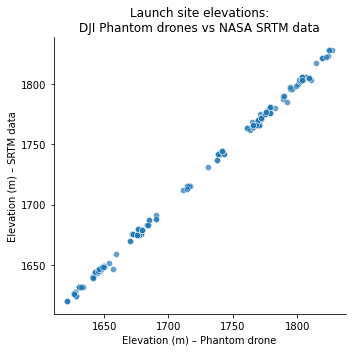

In [11]:
# How do DJI and SRTM launch site elevations compare?

plot = sns.relplot('launch_alt', 'launch_elev_SRTM', data = clip_df, kind = 'scatter', alpha = 0.7)
plt.xlabel('Elevation (m) – Phantom drone')
plt.ylabel('Elevation (m) – SRTM data')
plt.title('Launch site elevations:\nDJI Phantom drones vs NASA SRTM data')
plt.tight_layout()
elev_comparison = plot.fig
#elev_comparison.savefig('figures/FigA8.png')

/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alt_diff', ylabel='Density'>

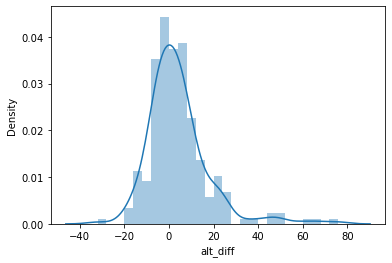

In [12]:
# What is the distribution of altitude differences between launch and group locations?
sns.distplot(clip_df['alt_diff'])

/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


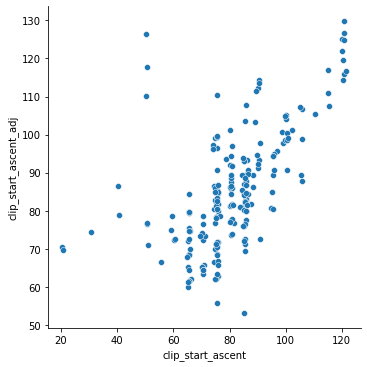

In [13]:
# How good an estimate of actual altitude over the group is the drone's ascent measurement?
sns.relplot('clip_start_ascent', 'clip_start_ascent_adj', data = clip_df, kind = 'scatter')

In [14]:
# Save drone_variables_clip2.csv
cols_to_keep = ['flight', 'clip_type', 'clip_start_vid', 'clip_start_log', 'launch_lat',
       'launch_lon', 'clip_start_lat', 'clip_start_lon',
       'launch-group_bear', 'clip_start_ascent_adj']

clip_df.drop(clip_df.columns.difference(cols_to_keep), axis = 1, inplace = True)
clip_df.to_csv('/Users/blaircostelloe/Dropbox/Publications/DroneDisturbance/drone-disturbance/supplement/processed-data/drone_variables_clip2.csv', index = False)